# <center>SEB Big Data Challenge - Jupyter Notebook</center>

<img src="./assets/lfma-nariai-seb-bankas.jpg" style="width: 25%"/>

## Table of contents:
0. Prerequisites
1. Acquisition
2. Exploration and Preprocessing
3. Analysis
4. Interpretation

## To do:
- Complete distributions function;
- XGBoost model;
- CatBoost model;
- Light GBM model;

<br>

## 0. Prerequisites:

In [11]:
# Clone external libraries:

!rm -rf ./cornelia
!git clone https://github.com/augustinasn/cornelia.git

# Packages:

from cornelia.imports import *
from cornelia.helpers import display_opts
from cornelia.extraction import read_feather, pickle_obj, unpickle_obj
from cornelia.preprocessing import match_cols, drop_cols, fill_NAs, one_hot_encode, category_encode, split_df
from cornelia.visualization import print_missing_data, print_descriptive_stats, print_categories, plot_data, print_df
from cornelia.analysis import score_regr, score_class, feature_importance, confidence, similiar_features, score_with_cols_dropped, pdps

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import json

# Options:

%matplotlib inline
%load_ext autoreload
%autoreload 2

display_opts(decimal_numbers=2,
             max_rows=1000,
             max_cols=30)

Cloning into 'cornelia'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 260 (delta 37), reused 42 (delta 19), pack-reused 200
Receiving objects: 100% (260/260), 44.68 KiB | 564.00 KiB/s, done.
Resolving deltas: 100% (155/155), done.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Acquisition

In [2]:
# Load raw data:

raw_train_df = read_feather(filename="raw_df_with_additional_features.f")
raw_test_df = read_feather(filename="test_df.f")

,id,y,amount_current_loan,term,credit_score,loan_purpose,yearly_income,home_ownership,bankruptcies,years_current_job,monthly_debt,years_credit_history,months_since_last_delinquent,open_accounts,credit_problems,credit_balance,max_open_credit
0,1000001,1,387574,short,None,debt_consolidation,nan,mortgage,1.00,10.00,20090.79,12,nan,10,1,242649,440440.00
1,1000002,0,72512,short,good,debt_consolidation,190798.00,rent,0.00,2.00,1460.91,6,nan,3,0,55062,129998.00
2,1000003,0,217404,short,good,debt_consolidation,1220313.00,mortgage,0.00,8.00,18293.39,10,nan,19,0,467514,513568.00
3,1000004,0,99999999,long,good,debt_consolidation,1435545.00,own,0.00,0.00,14312.70,18,27.00,7,0,157814,184140.00
4,1000005,1,215974,short,good,debt_consolidation,679250.00,rent,0.00,3.00,16464.45,14,53.00,6,0,216125,257840.00


,id,amount_current_loan,term,credit_score,loan_purpose,yearly_income,home_ownership,bankruptcies,years_current_job,monthly_debt,years_credit_history,months_since_last_delinquent,open_accounts,credit_problems,credit_balance,max_open_credit
0,1,438812,short,fair,debt_consolidation,1421010.00,mortgage,0.00,10.00,28595.95,21,nan,11,0,599545,826034
1,2,278344,long,None,debt_consolidation,723216.00,mortgage,0.00,0.00,15784.63,16,nan,9,0,271225,449504
2,3,155716,short,very_good,home_improvements,1956316.00,mortgage,0.00,8.00,21586.85,27,nan,12,0,28709,314468
3,4,442992,long,good,debt_consolidation,1339177.00,mortgage,0.00,10.00,23030.28,17,nan,7,0,766878,982234
4,5,412346,long,None,debt_consolidation,nan,mortgage,0.00,6.00,24058.94,10,68.00,11,0,524001,620950


## 2. Exploration and Preprocessing:

In [3]:
# Match columns:

raw_train_df = match_cols(df1=raw_train_df,
                          df2=raw_test_df,
                          omit=["y"])

No columns removed.


,id,amount_current_loan,term,credit_score,loan_purpose,yearly_income,home_ownership,bankruptcies,years_current_job,monthly_debt,years_credit_history,months_since_last_delinquent,open_accounts,credit_problems,credit_balance,max_open_credit,y
0,1000001,387574,short,None,debt_consolidation,nan,mortgage,1.00,10.00,20090.79,12,nan,10,1,242649,440440.00,1
1,1000002,72512,short,good,debt_consolidation,190798.00,rent,0.00,2.00,1460.91,6,nan,3,0,55062,129998.00,0
2,1000003,217404,short,good,debt_consolidation,1220313.00,mortgage,0.00,8.00,18293.39,10,nan,19,0,467514,513568.00,0
3,1000004,99999999,long,good,debt_consolidation,1435545.00,own,0.00,0.00,14312.70,18,27.00,7,0,157814,184140.00,0
4,1000005,215974,short,good,debt_consolidation,679250.00,rent,0.00,3.00,16464.45,14,53.00,6,0,216125,257840.00,1


In [4]:
# Observe missing data:

print_missing_data(dfs=[raw_train_df, raw_test_df],
                   labels=["train", "test"])

,Missing values in train (%),Missing values in test (%)
feature_name,,
id,0.00,0.00
amount_current_loan,0.00,0.00
term,0.00,0.00
credit_score,22.93,23.88
loan_purpose,0.00,0.00
yearly_income,18.89,19.47
home_ownership,0.00,0.00
bankruptcies,0.18,0.17
years_current_job,4.18,3.53


In [5]:
# Descriptive stats:

print_descriptive_stats(dfs=[raw_train_df, raw_test_df],
                        labels=["train", "test"])

,count,mean,std,min,25%,50%,75%,max
amount_current_loan (test),10000.00,11794868.60,31829206.38,21472.00,178238.50,310695.00,523094.00,99999999.00
amount_current_loan (train),9000000.00,13038047.72,33267502.46,10802.00,180268.00,316360.00,536184.00,99999999.00
bankruptcies (test),9983.00,0.12,0.35,0.00,0.00,0.00,0.00,5.00
bankruptcies (train),8983451.00,0.12,0.35,0.00,0.00,0.00,0.00,7.00
credit_balance (test),10000.00,292058.10,348668.55,0.00,111824.50,206824.50,362615.00,7225415.00
credit_balance (train),9000000.00,297664.97,376019.74,0.00,113278.00,210786.00,370804.00,32878968.00
credit_problems (test),10000.00,0.17,0.47,0.00,0.00,0.00,0.00,9.00
credit_problems (train),9000000.00,0.17,0.49,0.00,0.00,0.00,0.00,15.00
id (test),10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
id (train),9000000.00,5500000.50,2598076.36,1000001.00,3250000.75,5500000.50,7750000.25,10000000.00


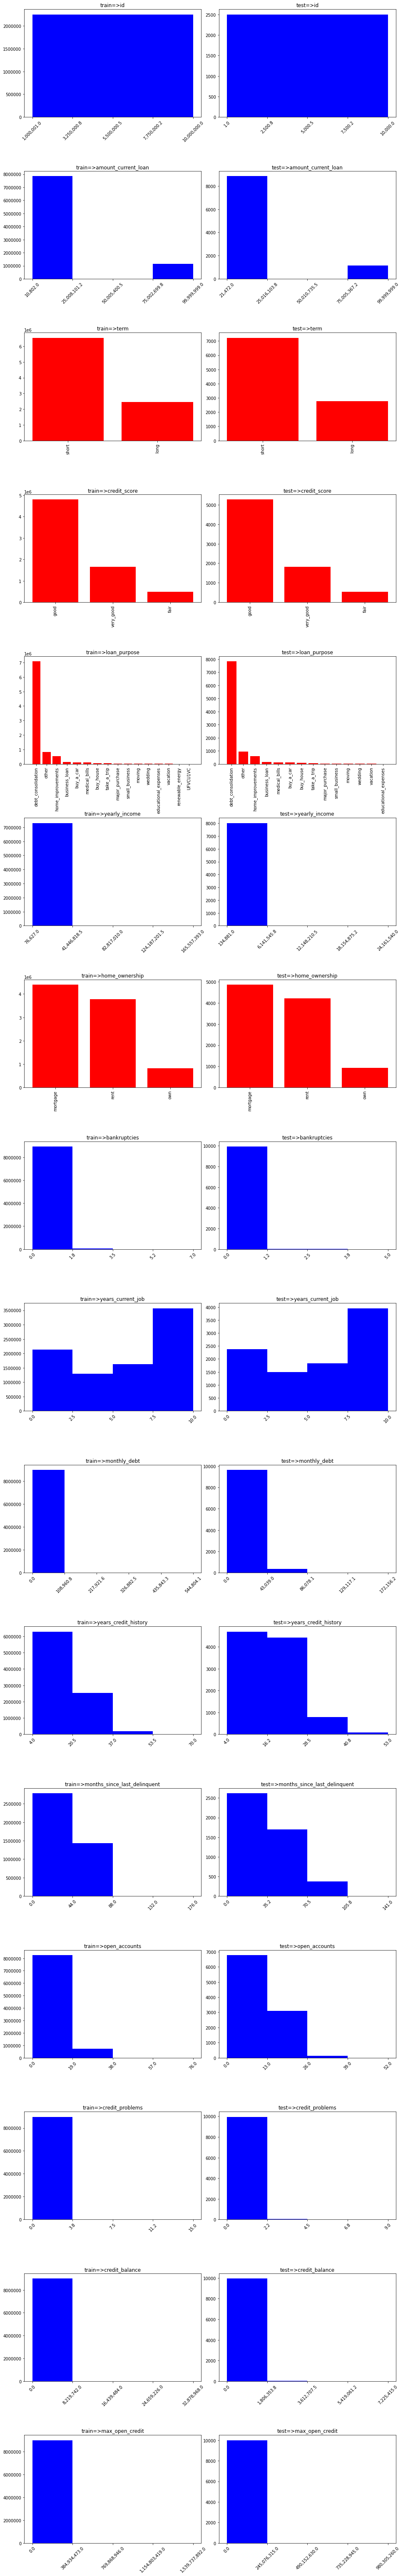

In [6]:
# Print histograms:
    
plot_data(dfs=[raw_train_df, raw_test_df],
          labels=["train", "test"],
          bench=1,
          n_bins=4)

In [9]:
# Drop a single row with an obfuscated feature:

raw_train_df = raw_train_df[raw_train_df["loan_purpose"] != "UFVCU1VC"]

term
long      719468
short    1201939
Name: y, dtype: int64
credit_score
fair         129540
good         831649
very_good    159372
Name: y, dtype: int64


ValueError: shape mismatch: objects cannot be broadcast to a single shape

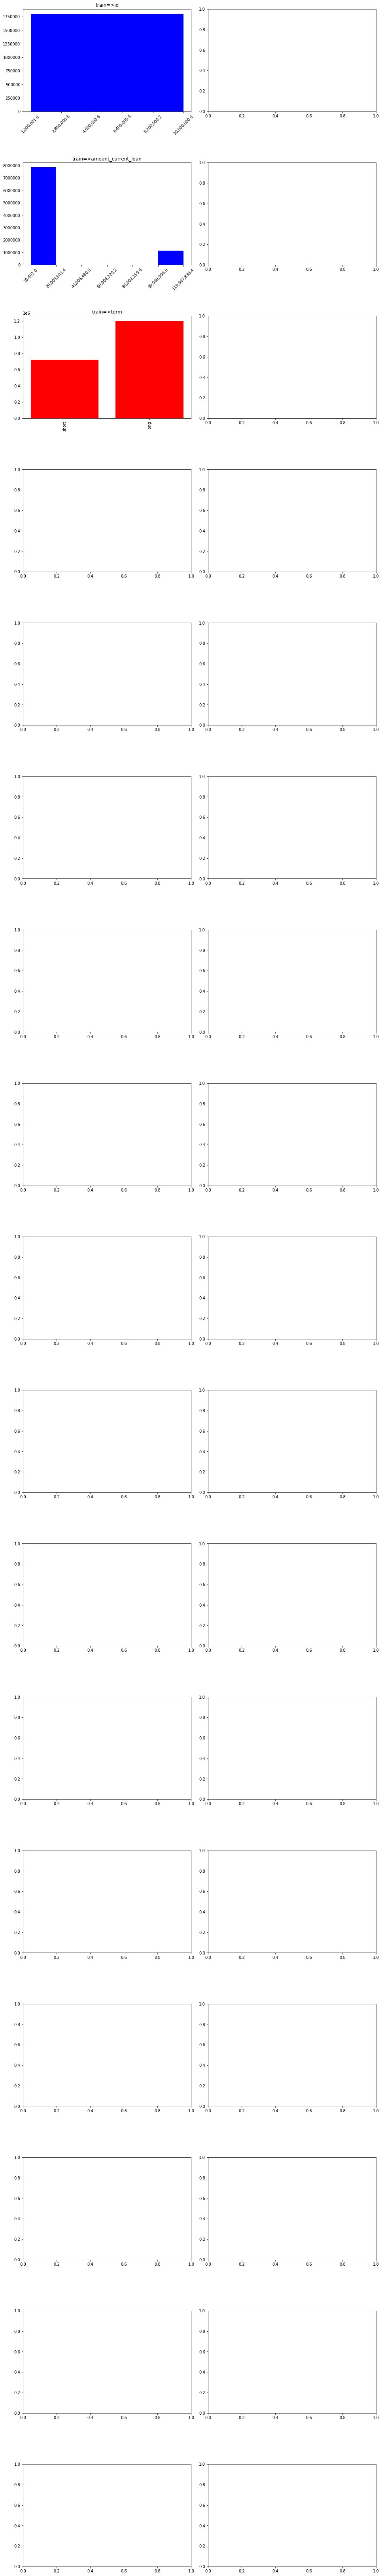

In [21]:
# Feature distributions around the target variable:

def plot_data(dfs, labels, bench, n_bins, target, distributions=False):
#     cols = [col for col in dfs[bench].columns if (("was_missing" not in col) and ("=>" not in col))]
    
    cols = [col for col in dfs[bench].columns]
    
    fig, axes = plt.subplots(nrows=len(cols),
                             ncols=max(2, len(dfs)),
                             figsize=(16, len(cols) * 7))
    
    fig.subplots_adjust(wspace=0.1,
                        hspace=0.5)
    
    for col, ax_tuple in zip(cols, axes):
        for ax, df, l in zip(ax_tuple, dfs, labels):
            
            if df[col].dtype == "object":
                if distributions:
                    x = df[col].unique()
                    y = df[[col, target]].groupby([col]).sum()[target]
                    print(y)
                else:
                    x = df[col].value_counts().index.to_list()
                    y = df[col].value_counts().to_list()
                
                ax.bar(x=x,
                       height=y,
                       color="red")
                
                ax.tick_params(axis="x",
                               labelrotation=90)
                
            else:
                lbound = float(df[col].min())
                ubound = float(df[col].max())
                step = (ubound - lbound) / (n_bins)

                bins = np.arange(lbound, ubound + step, step)

                ax.hist(x=df[col],
                        bins=bins,
                        color="blue")
                
                ax.set_xticks(bins)

                ax.ticklabel_format(useOffset=False,
                                    style="plain")

                ax.set_xticklabels([f"{round(v, 1):,}" for v in bins], rotation=45)
            
            ax.set_title(f"{l}=>{col}", fontdict={"fontsize":12,
                                                  "fontweight": "medium"})

plot_data(dfs=[raw_train_df],
          labels=["train"],
          bench=0,
          n_bins=5,
          target="y",
          distributions=True)

In [11]:
# Backup data:

pickle_obj([raw_train_df, raw_test_df], "train_test_dfs")

Object saved @ ./tmp/train_test_dfs.pkl


## 3. Analysis

In [2]:
# Unbackup data:

raw_train_df, raw_test_df = unpickle_obj("train_test_dfs")

### 3.1. Iteration #1 - initial run & interpretation (random forest)

In [3]:
# Fill NaNs:

train_df, test_df = fill_NAs(dfs=[raw_train_df, raw_test_df],
                                  omit=["y"],
                                  num_method="median",
                                  cat_method="mode",
                                  was_missing=True)

Done.


In [4]:
# One Hot Encode categorical columns:

train_df, test_df = one_hot_encode(dfs=[train_df, test_df],
                                   card_thresh=15)

Done.


In [5]:
# Split to train and validation:

train_X, train_y, valid_X, valid_y = split_df(df=train_df,
                                              target="y",
                                              train_p=0.90)

8999999 rows shuffled in df No.1.
Shapes of the outputs: (8099999, 51) (8099999,) (900000, 51) (900000,)


In [6]:
# Train model:

m = RandomForestClassifier(n_estimators=50,
                           max_samples=100_000,
                           max_features=0.75,
                           min_samples_leaf=3,
                           n_jobs=-1)
m.fit(train_X, train_y)

# Backup model:

pickle_obj(m, "model_1")

# Print score:

score_class(m, train_X, train_y, valid_X, valid_y)

Object saved @ ./tmp/model_1.pkl


,Train,Valid
Jacquard Score (%),0.83,0.83
True Positives (% of all positives),0.91,0.87
True Negatives (% of all negatives),0.83,0.83
False Positives (% of all positives),0.09,0.13
False Negatives (% of all negatives),0.17,0.17
Precision (What proportion of positive identifications was actually correct?),0.91,0.87
Recall (What proportion of actual positives was identified correctly?),0.84,0.84


In [7]:
# Feature importance:

fi_cols_to_drop = feature_importance(m=m,
                                     df=train_X,
                                     print_rows=15,
                                     to_keep_threshold=0.01)

# Backup feature importance result:

pickle_obj(fi_cols_to_drop, "fi_cols_to_drop")

,feature_name,importance
0,amount_current_loan,0.13
1,yearly_income=>was_missing,0.12
2,yearly_income,0.10
3,monthly_debt,0.09
4,max_open_credit,0.09
5,credit_balance,0.09
6,id,0.08
7,credit_score=>was_missing,0.06
8,years_credit_history,0.05
9,open_accounts,0.05


Object saved @ ./tmp/fi_cols_to_drop.pkl


In [8]:
# Confidence of predictions for each feature and it's each category:

confidence(model=m,
           df=valid_X,
           n_bins=5)

,preds_avg,preds_std
id_bin,,
"(9100000.999, 9280000.8]",0.25,0.35
"(9280000.8, 9460000.6]",0.25,0.35
"(9460000.6, 9640000.4]",0.25,0.35
"(9640000.4, 9820000.2]",0.25,0.35
"(9820000.2, 10000000.0]",0.25,0.35


,preds_avg,preds_std
amount_current_loan_bin,,
"(10801.999, 158224.0]",0.27,0.40
"(158224.0, 258060.0]",0.29,0.40
"(258060.0, 381810.0]",0.29,0.39
"(381810.0, 623876.0]",0.31,0.40
"(623876.0, 99999999.0]",0.11,0.14


,preds_avg,preds_std
yearly_income_bin,,
"(76626.999, 847400.0]",0.29,0.35
"(847400.0, 1166220.0]",0.26,0.33
"(1166220.0, 1193903.0]",0.29,0.43
"(1193903.0, 1671867.0]",0.23,0.32
"(1671867.0, 165557393.0]",0.20,0.30


,preds_avg,preds_std
bankruptcies,,
0.00,0.25,0.35
1.00,0.26,0.35
2.00,0.27,0.36
3.00,0.30,0.37
4.00,0.32,0.39
5.00,0.32,0.39
6.00,0.27,0.35
7.00,0.30,0.45


,preds_avg,preds_std
years_current_job,,
0.00,0.26,0.35
1.00,0.26,0.35
2.00,0.25,0.35
3.00,0.25,0.35
4.00,0.26,0.35
5.00,0.26,0.35
6.00,0.28,0.36
7.00,0.26,0.35
8.00,0.26,0.35


,preds_avg,preds_std
monthly_debt_bin,,
"(-0.001, 8887.44]",0.24,0.34
"(8887.44, 13803.88]",0.26,0.35
"(13803.88, 18913.74]",0.26,0.35
"(18913.74, 26318.8]",0.26,0.35
"(26318.8, 435843.28]",0.25,0.35


,preds_avg,preds_std
years_credit_history_bin,,
"(3.999, 13.0]",0.27,0.36
"(13.0, 16.0]",0.26,0.35
"(16.0, 18.0]",0.25,0.34
"(18.0, 23.0]",0.24,0.34
"(23.0, 70.0]",0.24,0.34


,preds_avg,preds_std
months_since_last_delinquent_bin,,
"(-0.001, 27.0]",0.26,0.35
"(27.0, 32.0]",0.25,0.34
"(32.0, 37.0]",0.25,0.35
"(37.0, 176.0]",0.26,0.35


,preds_avg,preds_std
open_accounts_bin,,
"(-0.001, 7.0]",0.25,0.35
"(7.0, 9.0]",0.25,0.35
"(9.0, 12.0]",0.25,0.34
"(12.0, 15.0]",0.25,0.35
"(15.0, 76.0]",0.26,0.35


,preds_avg,preds_std
credit_problems,,
0,0.25,0.35
1,0.26,0.35
2,0.27,0.35
3,0.28,0.36
4,0.29,0.36
5,0.34,0.39
6,0.26,0.33
7,0.30,0.41
8,0.21,0.29


,preds_avg,preds_std
credit_balance_bin,,
"(-0.001, 95931.0]",0.26,0.35
"(95931.0, 168693.4]",0.26,0.35
"(168693.4, 262029.0]",0.26,0.35
"(262029.0, 424308.0]",0.25,0.35
"(424308.0, 32878968.0]",0.24,0.34


,preds_avg,preds_std
max_open_credit_bin,,
"(-0.001, 241362.0]",0.27,0.36
"(241362.0, 388894.0]",0.27,0.36
"(388894.0, 578732.0]",0.26,0.35
"(578732.0, 899030.0]",0.24,0.34
"(899030.0, 1539737892.0]",0.22,0.32


,preds_avg,preds_std
id=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
amount_current_loan=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
term=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
credit_score=>was_missing,,
False,0.20,0.34
True,0.42,0.36


,preds_avg,preds_std
loan_purpose=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
yearly_income=>was_missing,,
False,0.24,0.33
True,0.30,0.44


,preds_avg,preds_std
home_ownership=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
bankruptcies=>was_missing,,
False,0.25,0.35
True,0.26,0.35


,preds_avg,preds_std
years_current_job=>was_missing,,
False,0.25,0.35
True,0.30,0.37


,preds_avg,preds_std
monthly_debt=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
years_credit_history=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
months_since_last_delinquent=>was_missing,,
False,0.26,0.35
True,0.25,0.34


,preds_avg,preds_std
open_accounts=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
credit_problems=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
credit_balance=>was_missing,,
False,0.25,0.35


,preds_avg,preds_std
max_open_credit=>was_missing,,
False,0.25,0.35
True,0.28,0.42


,preds_avg,preds_std
term=>short_OHE,,
False,0.33,0.38
True,0.23,0.33


,preds_avg,preds_std
term=>long_OHE,,
False,0.23,0.33
True,0.33,0.38


,preds_avg,preds_std
credit_score=>fair_OHE,,
False,0.25,0.34
True,0.30,0.41


,preds_avg,preds_std
credit_score=>very_good_OHE,,
False,0.28,0.36
True,0.14,0.28


,preds_avg,preds_std
credit_score=>good_OHE,,
False,0.18,0.31
True,0.28,0.36


,preds_avg,preds_std
loan_purpose=>medical_bills_OHE,,
False,0.25,0.35
True,0.26,0.36


,preds_avg,preds_std
loan_purpose=>renewable_energy_OHE,,
False,0.25,0.35
True,0.25,0.41


,preds_avg,preds_std
loan_purpose=>buy_a_car_OHE,,
False,0.25,0.35
True,0.25,0.34


,preds_avg,preds_std
loan_purpose=>other_OHE,,
False,0.25,0.35
True,0.26,0.35


,preds_avg,preds_std
loan_purpose=>small_business_OHE,,
False,0.25,0.35
True,0.30,0.37


,preds_avg,preds_std
loan_purpose=>major_purchase_OHE,,
False,0.25,0.35
True,0.26,0.34


,preds_avg,preds_std
loan_purpose=>buy_house_OHE,,
False,0.25,0.35
True,0.28,0.35


,preds_avg,preds_std
loan_purpose=>business_loan_OHE,,
False,0.25,0.35
True,0.30,0.38


,preds_avg,preds_std
loan_purpose=>vacation_OHE,,
False,0.25,0.35
True,0.29,0.38


,preds_avg,preds_std
loan_purpose=>moving_OHE,,
False,0.25,0.35
True,0.27,0.35


,preds_avg,preds_std
loan_purpose=>educational_expenses_OHE,,
False,0.25,0.35
True,0.24,0.35


,preds_avg,preds_std
loan_purpose=>home_improvements_OHE,,
False,0.25,0.35
True,0.24,0.34


,preds_avg,preds_std
loan_purpose=>debt_consolidation_OHE,,
False,0.26,0.35
True,0.25,0.35


,preds_avg,preds_std
loan_purpose=>wedding_OHE,,
False,0.25,0.35
True,0.22,0.33


,preds_avg,preds_std
loan_purpose=>take_a_trip_OHE,,
False,0.25,0.35
True,0.26,0.35


,preds_avg,preds_std
home_ownership=>mortgage_OHE,,
False,0.27,0.36
True,0.24,0.34


,preds_avg,preds_std
home_ownership=>own_OHE,,
False,0.25,0.35
True,0.27,0.36


,preds_avg,preds_std
home_ownership=>rent_OHE,,
False,0.24,0.34
True,0.27,0.36


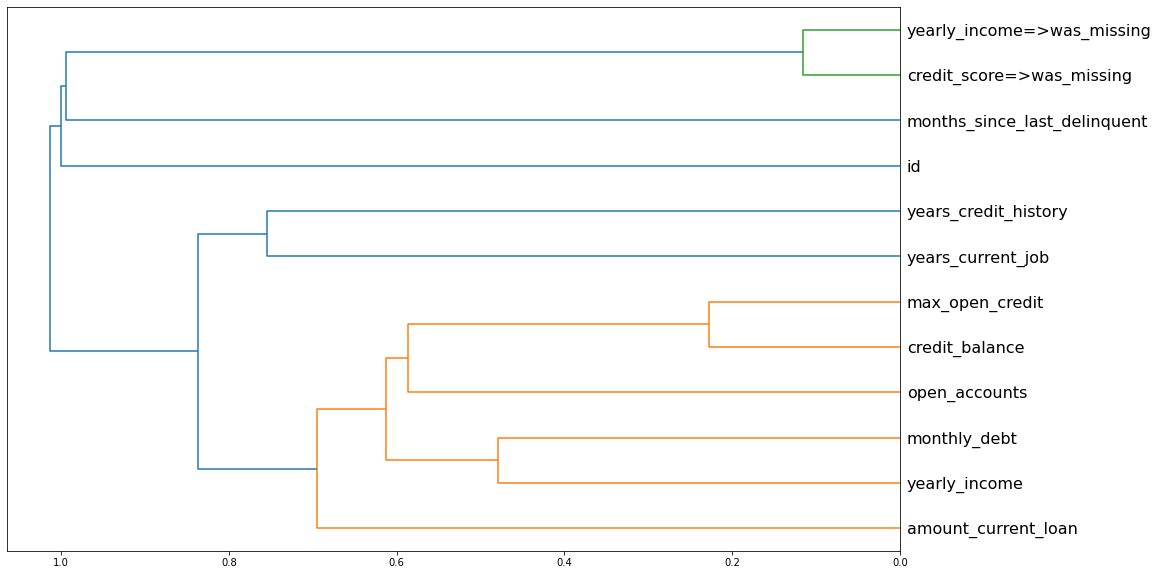

In [9]:
# Find similiar features:

similiar_features(train_X[[c for c in train_X.columns if c not in fi_cols_to_drop]])

In [10]:
# Check if dropping any of colinear feature will impact score:

potentially_colinear_features = ["yearly_income=>was_missing",
                                 "credit_score=>was_missing",
                                 "max_open_credit",
                                 "credit_balance",
                                 "monthly_debt",
                                 "yearly_income"]

In [11]:
# Assign safe to drop features to another variable:

colin_cols_to_drop = ["yearly_income=>was_missing", "max_open_credit", "credit_balance"]

# Backup feature importance result:

pickle_obj(colin_cols_to_drop, "colin_cols_to_drop")

Object saved @ ./tmp/colin_cols_to_drop.pkl


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


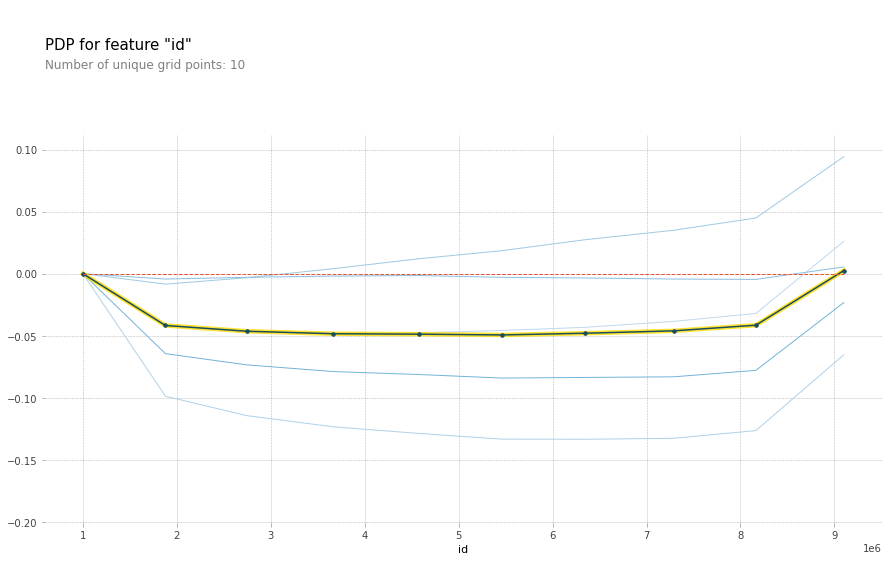

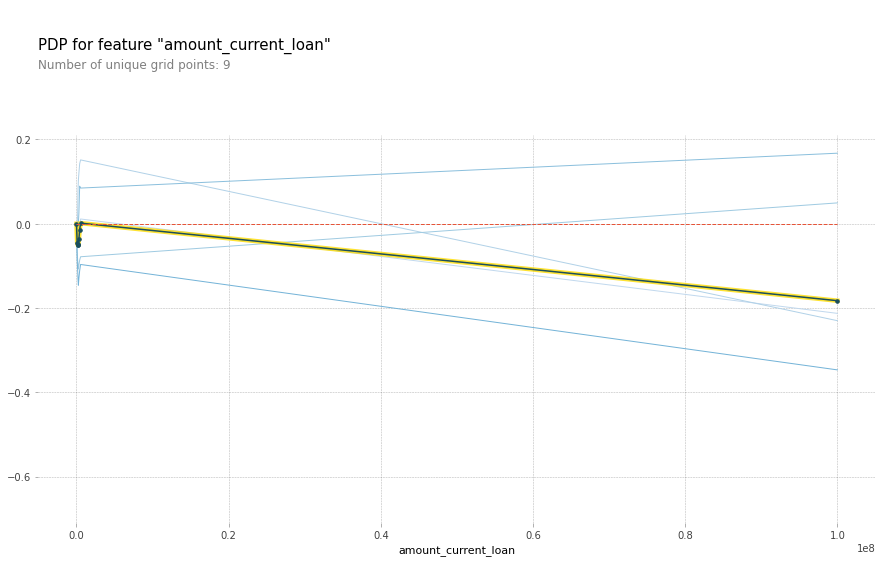

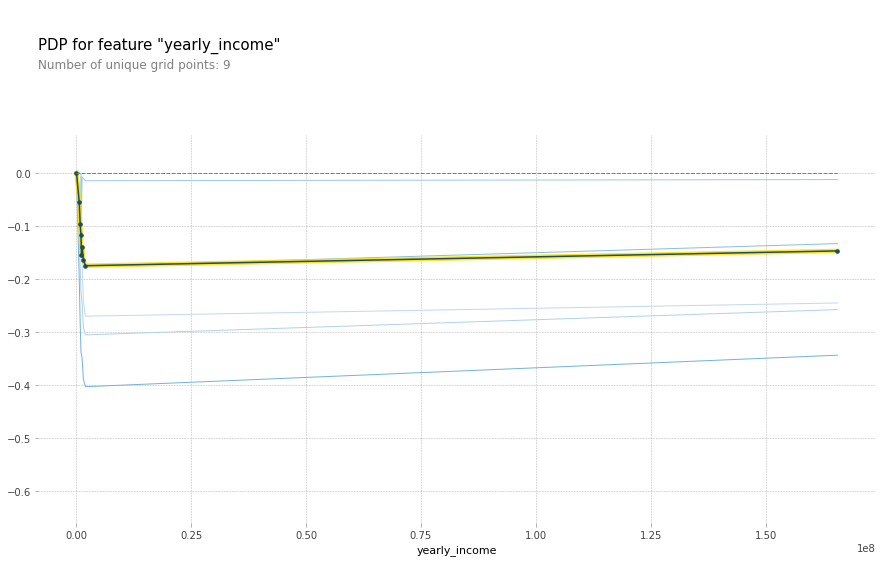

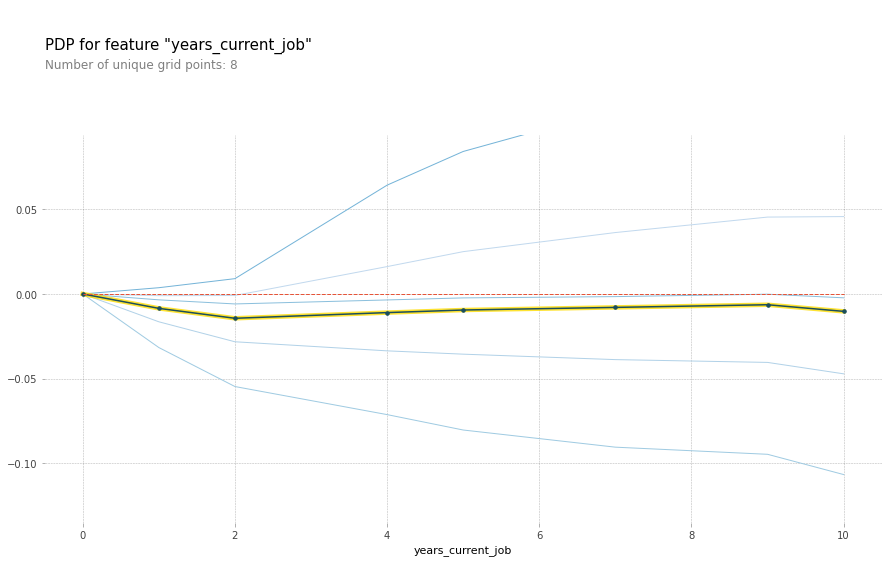

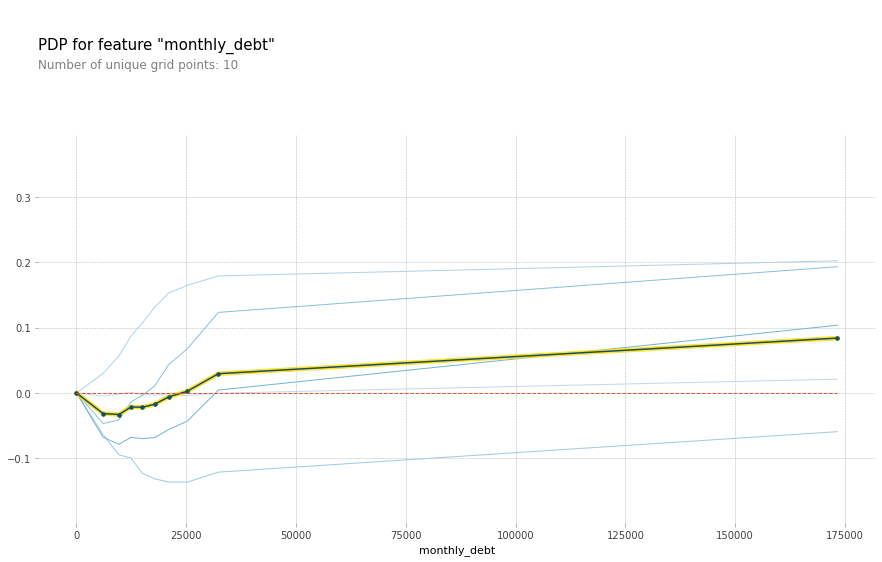

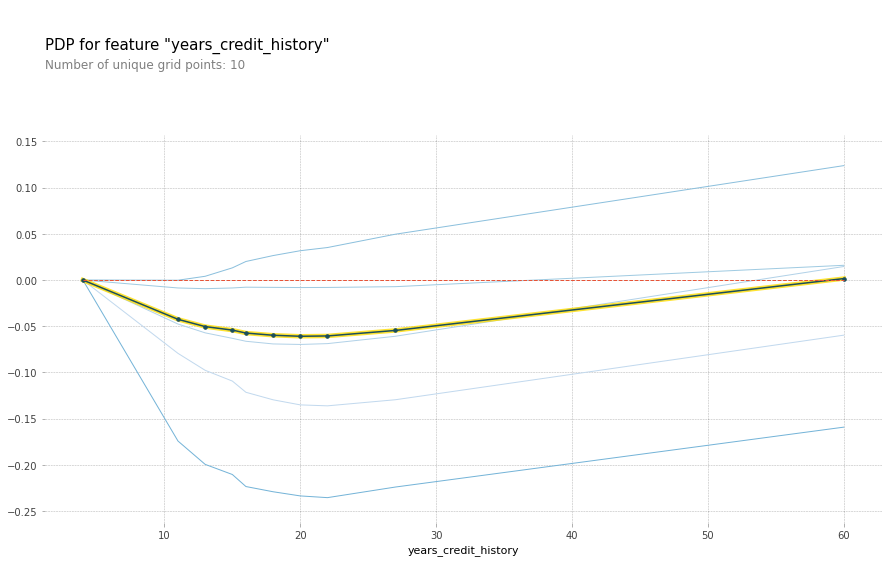

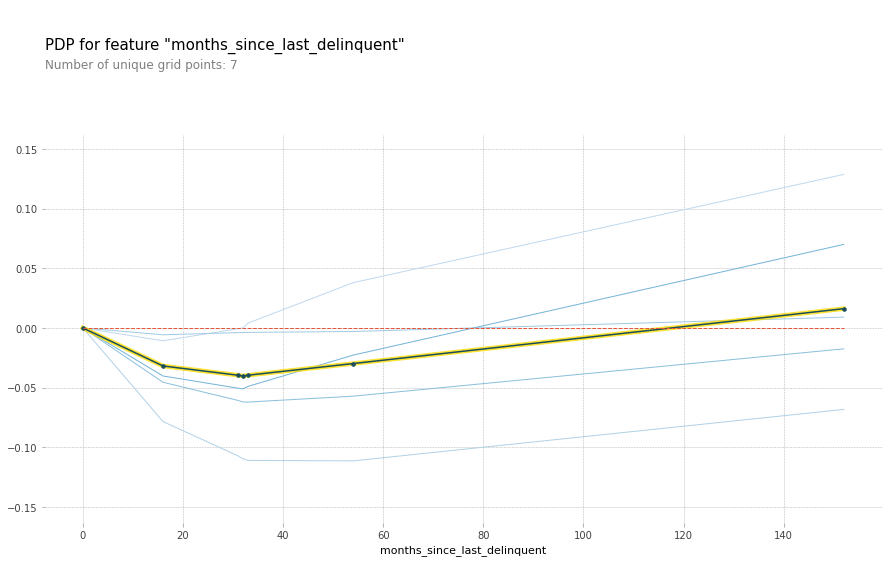

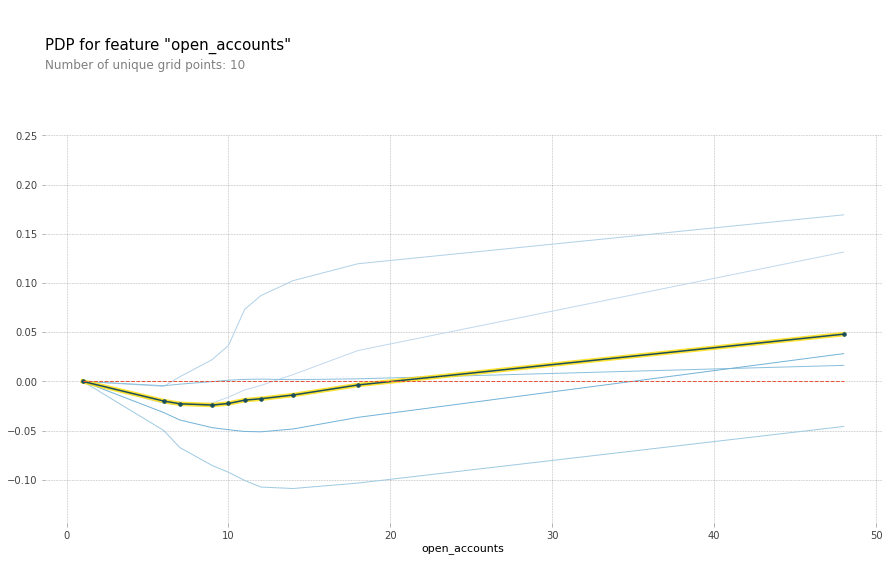

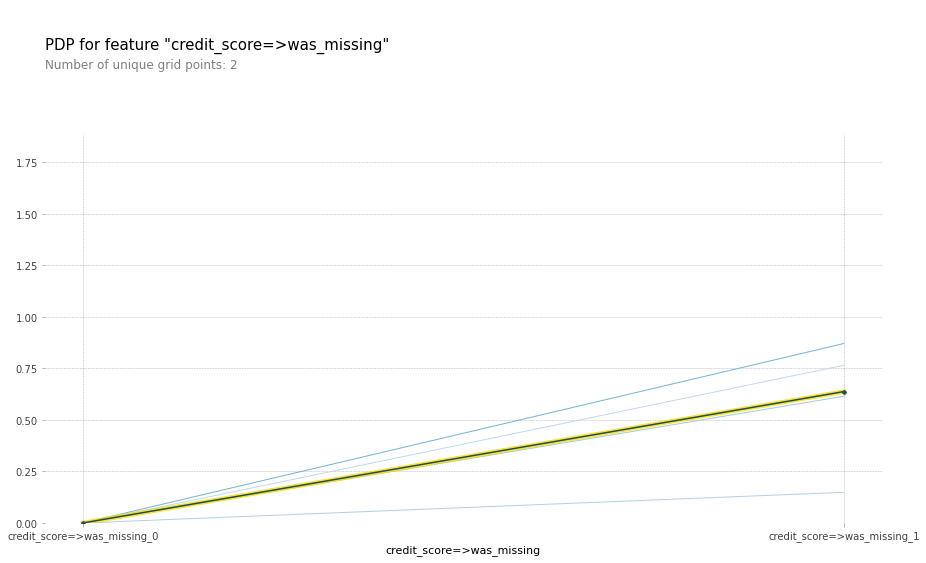

In [12]:
# Actual relationship between independant and dependant features (partial dependance):

pdps(model=m,
          data=train_X.sample(10_000),
          target="y",
          omit=fi_cols_to_drop + colin_cols_to_drop,
          clusters=5)


In [ ]:
def create_ensemble():

    # Train RFs:
    parameter_space = {"n_estimators": [25, 50, 100],
                       "max_samples": [50_000, 250_000, 500_000],
                       "max_features": [0.5, 0.8, None],
                       "min_samples_leaf": [1, 3, 5]}
    
    for p, vals in parameter_space.items():
        for val in vals:
            
    
create_ensemble()

### 3.5. Iteration #5 - XGBoost model

### 3.x. Submitting predictions